In [1]:
# 04_team_similarity.ipynb
# 🔍 Team Similarity Using K-Nearest Neighbors (KNN)

# 🛠 Requirements:
# - pandas, scikit-learn, matplotlib, seaborn (install via `pip install pandas scikit-learn matplotlib seaborn`)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_DIR = "./data"

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]

In [2]:
# 📂 Load team-level advanced season stats

stats_path = os.path.join(DATA_DIR, "advanced_season_stats", "2023.csv")
stats = pd.read_csv(stats_path)

# Filter to FBS teams
teams = stats[stats['conference'].notnull()].copy()

# Drop teams with missing metrics
metrics = [
    'offense_ppa', 'offense_successRate', 'offense_explosiveness',
    'defense_ppa', 'defense_successRate', 'defense_explosiveness',
    'offense_lineYards', 'offense_secondLevelYards', 'offense_pointsPerOpportunity',
    'defense_lineYards', 'defense_secondLevelYards', 'defense_pointsPerOpportunity'
]

teams = teams.dropna(subset=metrics)
teams = teams.reset_index(drop=True)
print(f"{len(teams)} teams with full data for 2023")

134 teams with full data for 2023


In [3]:
# 🧪 Standardize features for similarity analysis

X = teams[metrics].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
# 🧭 Fit KNN model (Euclidean distance)

knn = NearestNeighbors(n_neighbors=6, metric='euclidean')  # 5 neighbors + the team itself
knn.fit(X_scaled)

# Lookup table for team names
team_names = teams['team'].tolist()


In [5]:
# 🔍 Find similar teams to a given team
def find_similar_teams(team_name, top_n=5):
    try:
        idx = team_names.index(team_name)
    except ValueError:
        print(f"Team '{team_name}' not found.")
        return
    
    distances, indices = knn.kneighbors([X_scaled[idx]])
    
    print(f"Most similar teams to {team_name} (2023):")
    for i in range(1, top_n + 1):  # skip index 0 (itself)
        team_idx = indices[0][i]
        print(f" - {team_names[team_idx]} (distance: {distances[0][i]:.3f})")

# Example usage
find_similar_teams("Michigan")


Most similar teams to Michigan (2023):
 - Ohio State (distance: 1.829)
 - Penn State (distance: 2.720)
 - Notre Dame (distance: 2.936)
 - Ohio (distance: 3.065)
 - SMU (distance: 3.074)


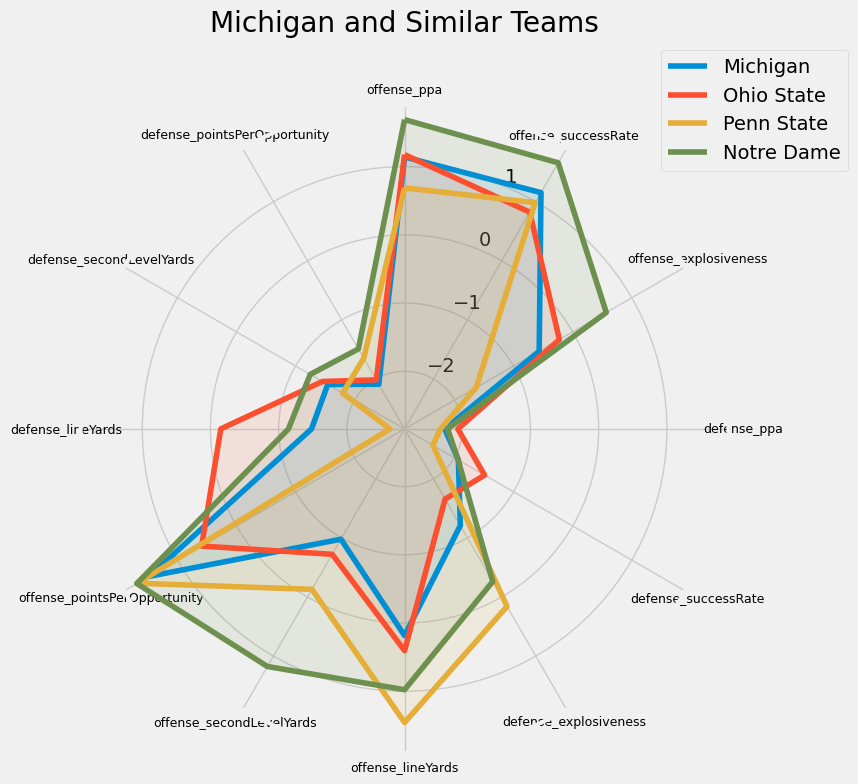

In [8]:
# 📊 Optional: Visualize your selected team vs. similar teams

def plot_similarity_radar(team_name):
    from math import pi
    
    idx = team_names.index(team_name)
    _, indices = knn.kneighbors([X_scaled[idx]])
    
    compare_idxs = indices[0][1:4]  # top 3 similar teams
    
    subset = teams.loc[[idx] + compare_idxs.tolist()]
    subset_scaled = pd.DataFrame(X_scaled[[idx] + compare_idxs.tolist()], columns=metrics)
    subset_scaled['team'] = subset['team'].values

    # Radar chart prep
    categories = metrics
    N = len(categories)

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for _, row in subset_scaled.iterrows():
        values = row[categories].tolist()
        values += values[:1]  # close the circle
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        ax.plot(angles, values, label=row['team'])
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks([n / float(N) * 2 * pi for n in range(N)])
    ax.set_xticklabels(categories, fontsize=9)
    ax.set_title(f"{team_name} and Similar Teams", y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.show()

# Example
plot_similarity_radar("Michigan")


In [7]:
# ✅ Summary

# In this notebook, you:
# - Loaded and standardized team metrics
# - Used KNN to find the most similar teams
# - Built a simple tool to explore team profiles
# - Visualized teams with radar plots

# 🧪 Try This:
# - Cluster teams using KMeans or DBSCAN
# - Compare year-over-year similarity for a single team
# - Build a matchup tool using similarity + next opponent